In [1]:
from keras import models, backend
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Activation
from keras.layers import UpSampling2D, BatchNormalization, Concatenate
from keras import datasets, utils

Using TensorFlow backend.
/home/inswave/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/inswave/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/inswave/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/inswave/anaconda3/lib/python3.7/site-packages/t

In [2]:
class UNET(models.Model):
    def __init__(self, org_shape, n_ch):
        ic = 3 if backend.image_data_format() == 'channels_last' else 1
        
        def conv(x,n_f, mp_flag=True):
            x = MaxPooling2D((2, 2), padding='same')(x) if mp_flag else x
            x = Conv2D(n_f, (3, 3), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('tanh')(x)
            x = Dropout(0.05)(x)
            x = Conv2D(n_f, (3, 3), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('tanh')(x)
            return x

        def deconv_unet(x, e, n_f):
            x = UpSampling2D((2, 2))(x)
            x = Concatenate(axis=ic)([x, e])
            x = Conv2D(n_f, (3, 3), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('tanh')(x)
            x = Conv2D(n_f, (3, 3), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('tanh')(x)
            return x
    
        original = Input(shape=org_shape)
        c1 = conv(original, 16, mp_flag=False)
        c2 = conv(c1, 32)
        
        encoded = conv(c2, 64)
        
        x = deconv_unet(encoded, c2, 32)
        x = deconv_unet(x, c1, 16)
        
        decoded = Conv2D(n_ch, (3, 3), activation='sigmoid', padding='same')(x)
        
        super().__init__(original, decoded)
        self.compile(optimizer='adadelta', loss='mse')

In [3]:
class DATA():
    def __init__(self, in_ch=None):
        (x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()
        if x_train.ndim == 4:
            if backend.image_data_format() == 'channels_first':
                n_ch, img_rows, img_cols = x_train.shape[1:]
            else:
                img_rows, img_cols, n_ch = x_train.shape[1:]
        else:
            img_rows, img_cols = x_train.shape[1:]
        
        in_ch = n_ch if in_ch is None else in_ch
        x_train = x_train.astype('float32')
        x_test = x_test.astype('float32')
        x_train /= 255
        x_test /= 255
        
        def RGB2Gray(X, fmt):
            if fmt == 'channels_first':
                R = X[:, 0:1]
                G = X[:, 1:2]
                B = X[:, 2:3]
            else:
                R = X[..., 0:1]
                G = X[..., 1:2]
                B = X[..., 2:3]
            return 0.299 * R + 0.587 * G + 0.114 * B
        
        def RGB2RG(x_train_out, x_test_out, fmt):
            if fmt == 'channels_first':
                x_train_in = x_train_out[:, :2]
                x_test_in = x_test_out[:, :2]
            else:
                x_train_in = x_train_out[..., :2]
                x_test_in = x_test_out[..., :2]
            return x_train_in, x_test_in
        
        
        if backend.image_data_format() == 'channels_first':
            x_train_out = x_train.reshape(x_train.shape[0], n_ch, img_rows, img_cols)
            x_test_out = x_test.reshape(x_test.shape[0], n_ch, img_rows, img_cols)
            input_shape = (in_ch, img_rows, img_cols)
        else:
            x_train_out = x_train.reshape(x_train.shape[0], img_rows, img_cols, n_ch)
            x_test_out = x_test.reshape(x_test.shape[0], img_rows, img_cols, n_ch)
            input_shape = (img_rows, img_cols, in_ch)

        if in_ch == 1 and n_ch == 3:
            x_train_in = RGB2Gray(x_train_out, backend.image_data_format())
            x_test_in = RGB2Gray(x_test_out, backend.image_data_format())
        elif in_ch == 2 and n_ch == 3:
            x_train_in, x_test_in = RGB2RG(x_train_out, x_test_out, backend.image_data_format())
        else:
            x_train_in = x_train_out
            x_test_in = x_test_out
        
        self.input_shape = input_shape
        self.x_train_in, self.x_train_out = x_train_in, x_train_out
        self.x_test_in, self.x_test_out = x_test_in, x_test_out
        self.n_ch = n_ch
        self.in_ch = in_ch


In [4]:
from keraspp.skeras import plot_loss
import matplotlib.pyplot as plt
import numpy as np

In [5]:
def show_images(data, unet):
    x_test_in = data.x_test_in
    x_test_out = data.x_test_out
    decoded_imgs = unet.predict(x_test_in)
    
    if backend.image_data_format() == 'channels_first':
        print(x_test_out.shape)
        x_test_out = x_test_out.swapaxes(1, 3).swapaxes(1, 2)
        print(x_test_out.shape)
        decoded_imgs = decoded_imgs.swapaxes(1, 3).swapaxes(1, 2)
        if data.in_ch == 1:
            x_test_in = x_test_in[:, 0, ...]
        elif data.in_ch == 2:
            x_test_in_tmp = np.zeros_like(x_test_out)
            x_test_in_tmp[..., :2] = x_test_in
            x_test_in = x_test_in_tmp
        else:
            x_test_in = x_test_in.swapaxes(1, 3).swapaxes(1, 2)
    else:
        if data.in_ch == 1:
            x_test_in = x_test_in[..., 0]
        elif data.in_ch == 2:
            x_test_in_tmp = np.zeros_like(x_test_out)
            x_test_in_tmp[..., :2] = x_test_in
            x_test_in = x_test_in_tmp
    
    n = 10
    plt.figure(figsize=(20, 6))
    for i in range(n):
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(x_test_in[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(decoded_imgs[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax = plt.subplot(3, n, i + 1 + n * 2)
        plt.imshow(x_test_out[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
    plt.show()

In [6]:
def main(in_ch=1, epochs=10, batch_size=128, fig=True):
    data = DATA(in_ch=in_ch)
    unet = UNET(data.input_shape, data.n_ch)
    
    history = unet.fit(data.x_train_in, data.x_train_out, epochs=epochs, batch_size=batch_size,
                      shuffle=True, validation_split=0.2)
    if fig:
        plot_loss(history)
        show_images(data, unet)



Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 22s 553us/step - loss: 0.0143 - val_loss: 0.0268
Epoch 2/10
40000/40000 [==============================] - 20s 490us/step - loss: 0.0095 - val_loss: 0.0210
Epoch 3/10
40000/40000 [==============================] - 20s 489us/step - loss: 0.0085 - val_loss: 0.0082
Epoch 4/10
40000/40000 [==============================] - 20s 490us/step - loss: 0.0080 - val_loss: 0.0076
Epoch 5/10
40000/40000 [==============================] - 20s 491us/step - loss: 0.0077 - val_loss: 0.0141
Epoch 6/10
40000/40000 [==============================] - 20s 490us/step - loss: 0.0075 - val_loss: 0.0134
Epoch 7/10
40000/40000 [==============================] - 20s 491us/step - loss: 0.0072 - val_loss: 0.0070
Epoch 8/10
40000/40000 [==============================] - 20s 490us/step - loss: 0.0071 - val_loss: 0.0225
Epoch 9/10
40000/40000 [==============================] - 20s 490us/step - loss: 0.0070 - va

/home/inswave/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


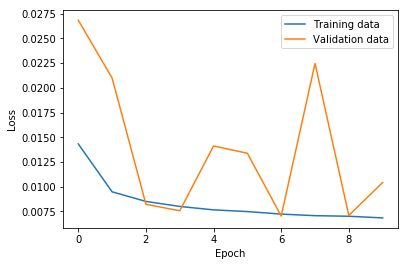

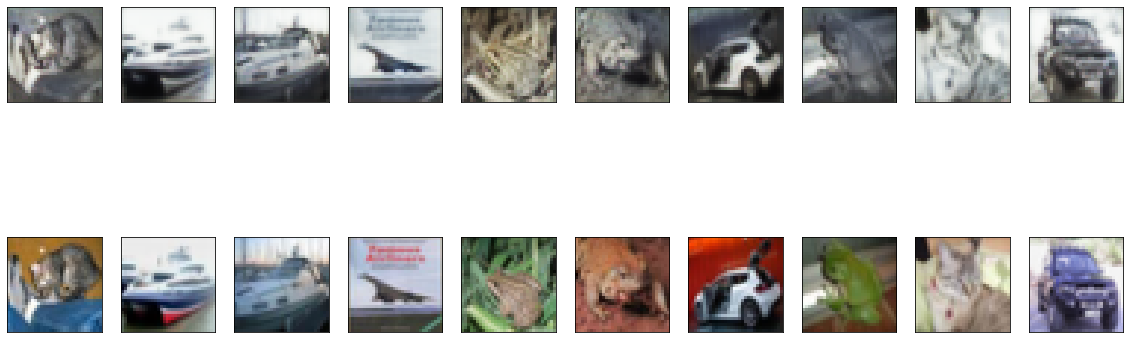

In [7]:
main(in_ch=1, epochs=10, batch_size=128, fig=True)